# SISO QPSK Simulation & Multipath Channel Analysis

本示例演示了两个主要部分：
1. **SISO 场景的仿真：** 在 AWGN 和瑞利衰落信道中传输 QPSK 信号，并绘制 SER 与 SNR 的关系。
2. **多径信道模型：** 给定
$$\displaystyle h(t) = \sum_{i=1}^{10}\delta\bigl(t - \tau_i\bigr),\quad \tau_i \in [50\text{m},\,100\text{m}],$$
分析在 $f=2.5\text{GHz}$ 时的频域响应 $H(f)$，并展示其实部和虚部的分布。

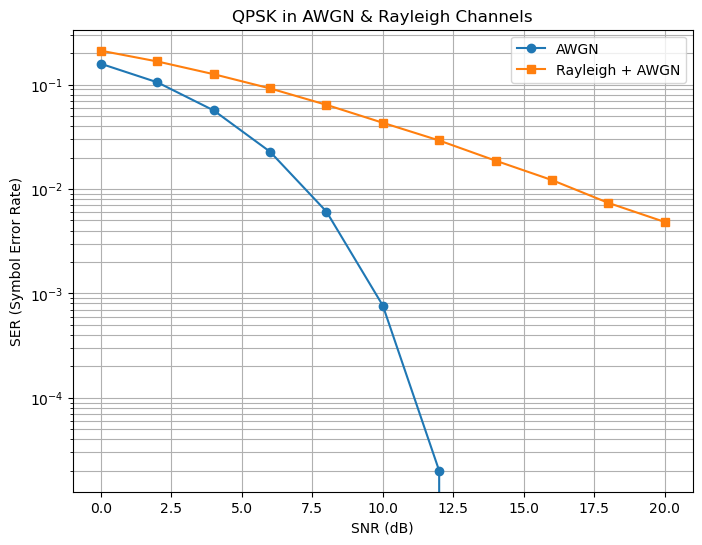

In [1]:
import numpy as np
import matplotlib.pyplot as plt

##############################
# 1. QPSK + AWGN/Rayleigh Sim
##############################

def qpsk_mod(bits):
    """QPSK 调制: 输入一维比特数组, 每2比特映射到一个复符号"""
    # 假设 bits 的长度为偶数
    bits_reshaped = bits.reshape(-1, 2)
    # QPSK 映射表: 00->(1+1j)/sqrt(2), 01->(1-1j)/sqrt(2), 10->(-1+1j)/sqrt(2), 11->(-1-1j)/sqrt(2)
    mapping = {
        (0, 0): (1+1j)/np.sqrt(2),
        (0, 1): (1-1j)/np.sqrt(2),
        (1, 0): (-1+1j)/np.sqrt(2),
        (1, 1): (-1-1j)/np.sqrt(2)
    }
    symbols = np.array([mapping[tuple(b)] for b in bits_reshaped])
    return symbols

def qpsk_demod(symbols):
    """QPSK 解调: 将接收的复符号判决回比特对"""
    # 判决: 取实部和虚部的正负
    bits_out = []
    for s in symbols:
        # 最近点判决
        real_sign = 0 if s.real >= 0 else 1
        imag_sign = 0 if s.imag >= 0 else 1
        bits_out.append(real_sign)
        bits_out.append(imag_sign)
    return np.array(bits_out)

def awgn_noise(signal, snr_db):
    """在给定 SNR (dB) 下向信号添加加性高斯白噪声"""
    snr_linear = 10**(snr_db/10)
    # 假设信号平均功率为 1
    noise_power = 1/snr_linear
    noise = np.sqrt(noise_power/2) * (np.random.randn(len(signal)) + 1j*np.random.randn(len(signal)))
    return signal + noise

def rayleigh_fading(signal):
    """对每个符号引入独立的瑞利衰落 (复高斯分量)"""
    # 生成与 signal 同长度的复衰落系数 h
    # h 的实部和虚部分别 ~ N(0, 0.5)
    h = (1/np.sqrt(2)) * (np.random.randn(len(signal)) + 1j*np.random.randn(len(signal)))
    return h*signal, h

##############################
# 2. Main Simulation        #
##############################
num_bits = 200000  # 比特数
bits = np.random.randint(0, 2, num_bits)

# 调制
symbols = qpsk_mod(bits)

snr_db_list = np.arange(0, 21, 2)  # 0~20 dB, 步进2
ser_awgn = []
ser_rayleigh = []

for snr_db in snr_db_list:
    # 1) AWGN 信道
    rx_awgn = awgn_noise(symbols, snr_db)
    bits_hat_awgn = qpsk_demod(rx_awgn)
    ser_awgn.append(np.mean(bits_hat_awgn != bits))

    # 2) 瑞利信道 + AWGN
    faded_signal, h = rayleigh_fading(symbols)
    rx_rayleigh = awgn_noise(faded_signal, snr_db)
    # 需要进行信道均衡 (单符号除法)
    rx_equalized = rx_rayleigh / (h + 1e-15)
    bits_hat_rayleigh = qpsk_demod(rx_equalized)
    ser_rayleigh.append(np.mean(bits_hat_rayleigh != bits))

# 绘制 SER vs. SNR
plt.figure(figsize=(8,6))
plt.semilogy(snr_db_list, ser_awgn, 'o-', label='AWGN')
plt.semilogy(snr_db_list, ser_rayleigh, 's-', label='Rayleigh + AWGN')
plt.xlabel('SNR (dB)')
plt.ylabel('SER (Symbol Error Rate)')
plt.title('QPSK in AWGN & Rayleigh Channels')
plt.grid(True, which='both')
plt.legend()
plt.show()


## 3. 多径信道模型

给定
$$\displaystyle h(t) = \sum_{i=1}^{10} \delta\bigl(t - \tau_i\bigr),\quad \tau_i \in [50\text{m},\,100\text{m}],$$
并假设电磁波在真空中传播速度 $c = 3\times 10^8\,\text{m/s}$。那么其在频率 $f = 2.5\,\text{GHz}$ 下的频域响应可表示为：
$$\displaystyle H(f) = \sum_{i=1}^{10} e^{-j 2\pi f\,\frac{\tau_i}{c}}.$$

下方代码演示如何生成 $\tau_i$ 并统计 $H(2.5\,\text{GHz})$ 的实部和虚部分布。

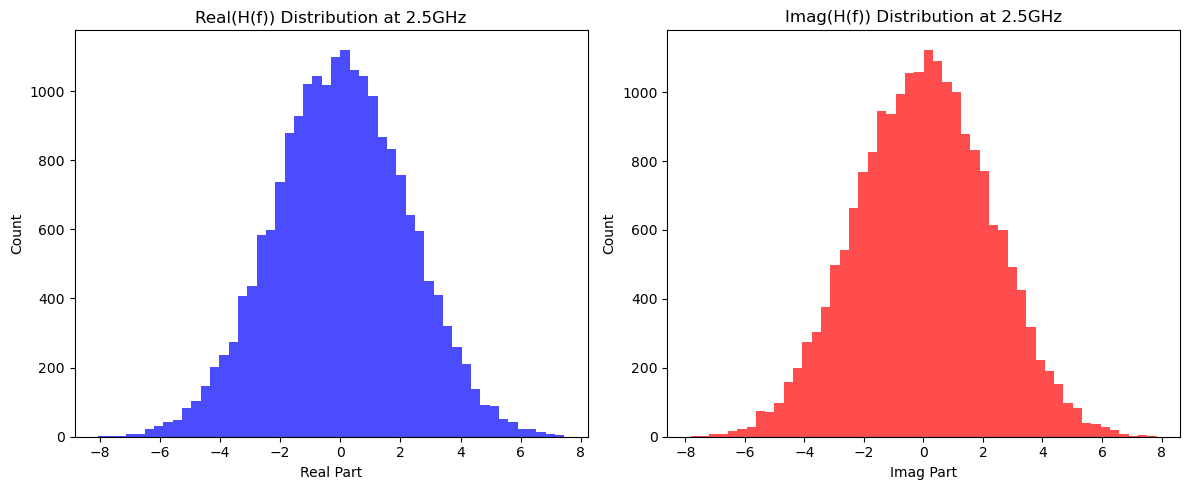

In [3]:
def multipath_channel_response(num_samples=10000, f=2.5e9, c=3e8):
    """生成多次随机的 {tau_i}, 计算 H(f) = sum exp(-j 2 pi f tau_i / c)."""
    real_parts = []
    imag_parts = []

    for _ in range(num_samples):
        # 生成10个时延 tau_i, 均匀分布在 [50, 100] (单位: 米)
        tau_meters = np.random.uniform(50, 100, 10)
        # 转换为时间
        tau_seconds = tau_meters / c
        # 计算每条径的相位
        phasors = np.exp(-1j * 2 * np.pi * f * tau_seconds)
        # 叠加得到 H(f)
        H_f = np.sum(phasors)
        real_parts.append(H_f.real)
        imag_parts.append(H_f.imag)

    return np.array(real_parts), np.array(imag_parts)

# 计算并绘图
real_vals, imag_vals = multipath_channel_response(num_samples=20000)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.hist(real_vals, bins=50, color='b', alpha=0.7)
plt.title('Real(H(f)) Distribution at 2.5GHz')
plt.xlabel('Real Part')
plt.ylabel('Count')

plt.subplot(1,2,2)
plt.hist(imag_vals, bins=50, color='r', alpha=0.7)
plt.title('Imag(H(f)) Distribution at 2.5GHz')
plt.xlabel('Imag Part')
plt.ylabel('Count')

plt.tight_layout()
plt.show()
